In [21]:
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

sns.set_theme(style="darkgrid")

import utils as utils
import utils_plots as utils_plots
import utils_features as utils_features
from utils_models import ForecastingModel
import copied_feature_engineering as copied_functions

In [43]:
file_path = 'train_v_2_kaggle_23.csv'
df_kaggle = pd.read_csv(file_path)

In [44]:
# Preprocessing

df_kaggle['date'] = pd.to_datetime(df_kaggle['date'], format='%Y-%m-%d', errors='coerce')
df_kaggle['sales_units'] = pd.to_numeric(df_kaggle['sales_units'], errors='coerce')
df_kaggle['inventory_units'] = pd.to_numeric(df_kaggle['inventory_units'], errors='coerce')

df_kaggle['sku'] = df_kaggle['reporterhq_id'].astype(str) + "_" + df_kaggle['product_number'].astype(str)

categorical_columns = ['id', 'product_number', 'reporterhq_id', 'prod_category', 'display_size', 'segment', 'sku']
for col in categorical_columns:
    df_kaggle[col] = df_kaggle[col].astype('category')
    df_kaggle[col] = df_kaggle[col].cat.remove_unused_categories()

# Drop columns
df_kaggle.drop(columns=['specs'], inplace=True)

# Missing dates
utils.fill_in_missing_dates(df_kaggle).shape

# Resample weekly for each sku
# utils.looks_for_missing_dates(df_kaggle)
df_kaggle = utils.fill_in_missing_dates(df_kaggle)

# Interpolation and fill-in function
def interpolate_sku(group):
    group = group.sort_values(by='date')
    group = group.set_index('date')  
    group['sales_units'] = group['sales_units'].interpolate(method='time')
    group['inventory_units'] = group['inventory_units'].interpolate(method='time')
    return group.reset_index()

df_kaggle = df_kaggle.groupby('sku', group_keys=False).apply(interpolate_sku)
df_kaggle = df_kaggle.dropna(subset=['inventory_units'])

/Users/matteogiaretti/Python/hp_use_case/utils.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_dates_ranges = df.groupby(group_col)[date_col].agg(['min', 'max']).reset_index()
/Users/matteogiaretti/Python/hp_use_case/utils.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_dates_ranges = df.groupby(group_col)[date_col].agg(['min', 'max']).reset_index()
/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_7506/1728688142.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior o

In [45]:
# Generate features
df_kaggle = utils_features.features_time_related(df_kaggle)
df_kaggle = utils_features.features_lag(df=df_kaggle, col='inventory_units', lags=[13])
#df_kaggle = utils_features.features_lag(df=df_kaggle, col='sales_units', lags=[13, 14, 15])
#df_kaggle = utils_features.features_rolling(df=df_kaggle, col='sales_units', window_sizes=[4, 8])

In [46]:
df = df_kaggle.copy()
df = df[df['segment'] == 'Premium'].rename(columns={'inventory_units': 'y'}).reset_index(drop=True).set_index('date')
dropped_columns = df[['y', 'id']]
X_train = df.drop(columns=dropped_columns)
y_train = df[["y"]]

In [62]:
lgb_params = {
    "bagging_fraction": 0.418,
    "bagging_seed": 11,
    "boosting_type": "gbdt",
    "feature_fraction": 0.379,
    "learning_rate": 0.005,
    "max_depth": -1,
    "metric": "rmse",
    "min_child_weight": 0.034,
    "min_data_in_leaf": 106,
    "num_leaves": 555,
    "objective": "regression",
    "random_state": 222,
    "reg_alpha": 0.3899,
    "reg_lambda": 0.648,
    "verbosity": -1,
}

lgb_params = {
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': np.float64(0.9914924607394691),
    'importance_type': 'split',
    'learning_rate': np.float64(0.027590738215604697),
    'max_depth': np.int64(10),
    'min_child_samples': 25,
    'min_child_weight': 0.034,
    'min_split_gain': 0.0,
    'n_estimators': 1000,
    'n_jobs': None,
    'num_leaves': 157,
    'objective': 'regression',
    'random_state': 222,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'subsample': np.float64(0.6006545748134953),
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'bagging_fraction': 0.418,
    'bagging_seed': 11,
    'feature_fraction': 0.379,
    'metric': 'rmse',
    'min_data_in_leaf': 106,
    'verbosity': -1,
    }

In [77]:
fc_model = ForecastingModel(hyperparameters=lgb_params)

In [63]:
model = LGBMRegressor(**lgb_params)
model.fit(X=X_train, y=y_train)

LGBMRegressor(bagging_fraction=0.418, bagging_seed=11,
              colsample_bytree=np.float64(0.9914924607394691),
              feature_fraction=0.379,
              learning_rate=np.float64(0.027590738215604697),
              max_depth=np.int64(10), metric='rmse', min_child_samples=25,
              min_child_weight=0.034, min_data_in_leaf=106, n_estimators=1000,
              num_leaves=157, objective='regression', random_state=222,
              reg_alpha=0, reg_lambda=0,
              subsample=np.float64(0.6006545748134953), verbosity=-1)

In [64]:
time_index = X_train.index.get_level_values(-1)
time_mask = time_index > time_index.max() - np.timedelta64(13, "W")
X_train_recent = X_train.loc[time_mask]
y_train_recent = y_train.loc[time_mask]

In [65]:
y_pred_train = model.predict(X=X_train_recent)

df_preds = pd.DataFrame(
    data={
        "sku": X_train_recent["sku"],
        "y_pred": y_pred_train,
        "y": y_train_recent['y']
    },
    index=X_train_recent.index
)

In [66]:
num_select = 4
# list_skus = np.random.choice(df_preds['sku'].unique(), size=num_select, replace=False) # Random
list_skus = X_train_recent["sku"].cat.remove_unused_categories().value_counts().index[:num_select].values # More entries in the dataset
# list_skus = X_test["sku"].cat.remove_unused_categories().value_counts().index[-num_select:].values # Less entries in the dataset

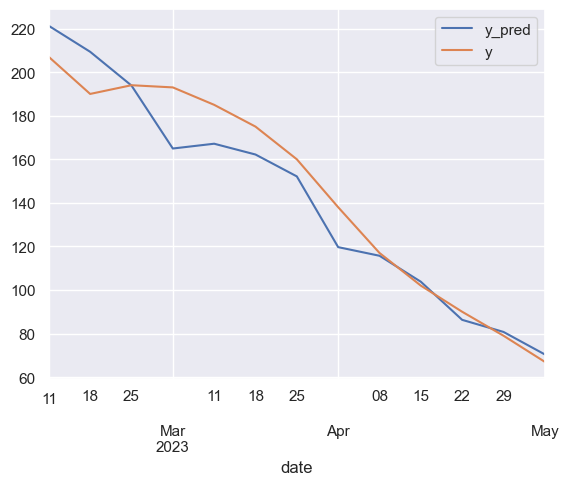

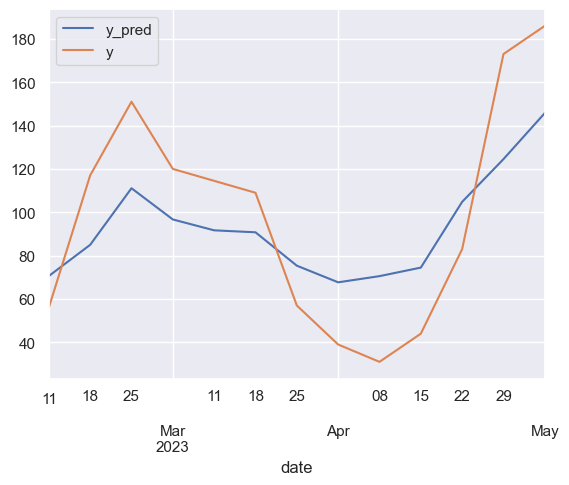

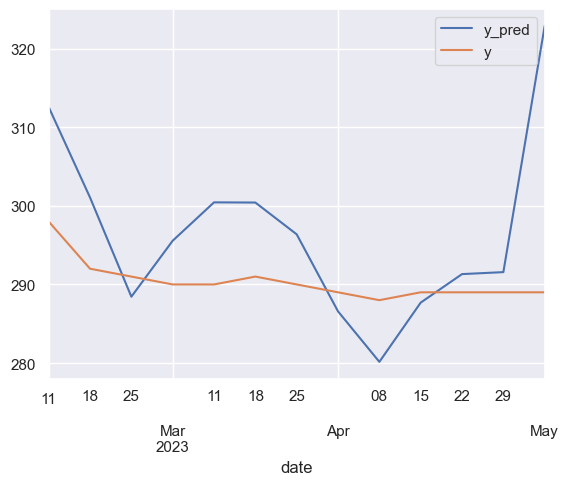

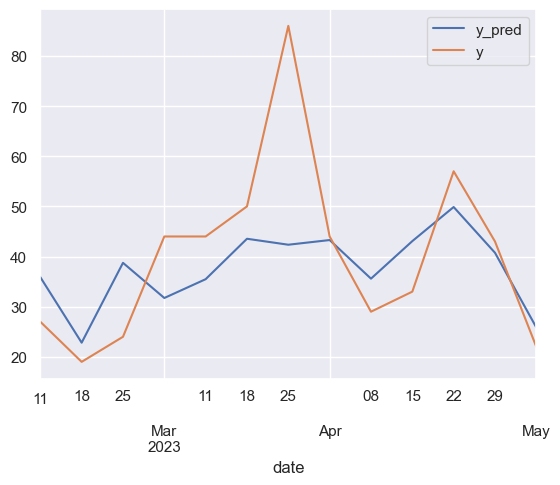

In [67]:
for sku in list_skus:
    temp = df_preds[df_preds['sku'] == sku]
    temp[['y_pred',	'y']].plot()

In [32]:
import scipy

In [61]:
np.append(-1, np.arange(3, 16))

array([-1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [68]:
param_distributions = {
    "learning_rate": scipy.stats.uniform(loc=0.003, scale=0.19),  # Default is 0.1. Ranges from loc to loc+scale.
    "num_leaves": scipy.stats.randint(8, 256),  # Default is 31
    "max_depth": np.append(-1, np.arange(3, 16)),  # Default is -1
    "min_child_samples": scipy.stats.randint(5, 300),  # Default is 20. AKA min_data_in_leaf.
    "subsample": scipy.stats.uniform(loc=0.5, scale=0.5),  # Default is 1. AKA bagging_fraction.
    "colsample_bytree": scipy.stats.uniform(loc=0.5, scale=0.5),  # Default is 1.0. AKA feature_fraction.
    "reg_alpha": [0, 0.01, 1, 2, 5, 7, 10, 50, 100],  # Default is 0. AKA lambda_l1.
    "reg_lambda": [0, 0.01, 1, 5, 10, 20, 50, 100],  # Default is 0. AKA lambda_l2.
    "n_estimators": [10, 50, 100, 500, 1000, 1500, 2000, 5000] # Default is 100.
}

In [69]:
from sklearn.model_selection import RandomizedSearchCV

In [70]:
random_search = RandomizedSearchCV(model,
                                   param_distributions=param_distributions,
                                   n_iter=40,
                                   cv=3,
                                   # cv=sklearn.model_selection.ShuffleSplit(n_splits=1, test_size=.25, random_state=46),  # Train/test alternative to k-folds
                                   scoring="neg_root_mean_squared_error",
                                   n_jobs=-1)


In [71]:
random_search.fit(X_train, y_train,
                  eval_set=[(X_train, y_train)],
                  callbacks=[lgb.early_stopping(20)])

Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 56.9871
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 57.8656
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 71.1179
Training until validation scores don'

/Users/matteogiaretti/Python/hp_use_case/.venv/lib/python3.13/site-packages/lightgbm/callback.py:341: UserWarning: Only training set found, disabling early stopping.
  _log_warning("Only training set found, disabling early stopping.")


RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(bagging_fraction=0.418,
                                           bagging_seed=11,
                                           colsample_bytree=np.float64(0.9914924607394691),
                                           feature_fraction=0.379,
                                           learning_rate=np.float64(0.027590738215604697),
                                           max_depth=np.int64(10),
                                           metric='rmse', min_child_samples=25,
                                           min_child_weight=0.034,
                                           min_data_in_leaf=106,
                                           n_estimators=1000, num_leaves=157,
                                           objective=...
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x11ec122c0>,
                                        'n_estimators': [10, 50, 100, 500, 1000,
                                                         1500, 2000, 5000],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x177e8e990>,
                                        'reg_alpha': [0, 0.01, 1, 2, 5, 7, 10,
                                                      50, 100],
                                        'reg_lambda': [0, 0.01, 1, 5, 10, 20,
                                                       50, 100],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x14f590510>},
                   scoring='neg_root_mean_squared_error')

In [72]:
best_model = random_search.best_estimator_
optimal_params = best_model.get_params()
optimal_params["n_estimators"] = best_model.best_iteration_

In [73]:
best_model

LGBMRegressor(bagging_fraction=0.418, bagging_seed=11,
              colsample_bytree=np.float64(0.8029677051366595),
              feature_fraction=0.379,
              learning_rate=np.float64(0.05385151267936273),
              max_depth=np.int64(5), metric='rmse', min_child_samples=239,
              min_child_weight=0.034, min_data_in_leaf=106, n_estimators=50,
              num_leaves=158, objective='regression', random_state=222,
              reg_alpha=2, reg_lambda=20,
              subsample=np.float64(0.6624990112594646), verbosity=-1)

In [74]:
optimal_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': np.float64(0.8029677051366595),
 'importance_type': 'split',
 'learning_rate': np.float64(0.05385151267936273),
 'max_depth': np.int64(5),
 'min_child_samples': 239,
 'min_child_weight': 0.034,
 'min_split_gain': 0.0,
 'n_estimators': 0,
 'n_jobs': None,
 'num_leaves': 158,
 'objective': 'regression',
 'random_state': 222,
 'reg_alpha': 2,
 'reg_lambda': 20,
 'subsample': np.float64(0.6624990112594646),
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'bagging_fraction': 0.418,
 'bagging_seed': 11,
 'feature_fraction': 0.379,
 'metric': 'rmse',
 'min_data_in_leaf': 106,
 'verbosity': -1}

In [75]:
best_model.best_iteration_

0